# Physics-Based Simulator Synthetic Dataset

Source Reference: https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/DataGeneration.ipynb

In [1]:
import pandas as pd

tel_df = pd.read_parquet('../data/simulator/telemetry/telemetry-20170515-000000.parquet')
tel_df

C:\Users\jjoul\AppData\Local\Temp\ipykernel_15520\2237625287.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID
timestamp,,,,,,,
2017-05-15 00:48:00,1000,19.92,100.93,587.07,23.33,236.98,M_0031
2017-05-15 00:48:01,1000,20.09,100.91,879.46,27.65,564.25,M_0031
2017-05-15 00:48:02,1000,19.92,101.05,1031.74,32.77,861.95,M_0031
2017-05-15 00:48:03,1000,20.04,101.10,1100.26,38.82,1084.90,M_0031
2017-05-15 00:48:04,1000,19.93,101.04,1145.01,45.97,1290.41,M_0031
...,...,...,...,...,...,...,...
2017-05-15 00:50:55,0,20.04,100.93,-3.50,138.59,73.42,M_0975
2017-05-15 00:50:56,0,19.93,101.07,-1.09,138.56,86.14,M_0975
2017-05-15 00:50:57,0,20.05,101.00,1.20,138.68,100.44,M_0975


In [2]:
logs_df = pd.read_parquet('../data/simulator/logs/logs.parquet')
logs_df

,machineID,level,code
timestamp,,,
2017-06-09 07:51:13,M_0108,CRITICAL,F1
2017-06-09 14:59:34,M_0084,CRITICAL,F2
2017-06-09 14:00:00,M_0108,INFO,fixed
2017-06-09 16:00:00,M_0084,INFO,fixed
2017-06-11 11:52:04,M_0955,CRITICAL,F1
...,...,...,...
2017-08-14 07:00:00,M_0702,INFO,fixed
2017-08-14 09:00:00,M_0497,INFO,fixed
2017-08-14 11:02:26,M_0435,CRITICAL,F2


['logs.parquet']

In [32]:

def build_machine_failure_times(logs_df: pd.DataFrame) -> dict[str, pd.Timestamp]:
    machine_failure_times: dict[str, pd.Timestamp] = {}

    for index, row in logs_df.iterrows():
        if row['level'] == 'CRITICAL':
            if row['machineID'] not in machine_failure_times:
                machine_failure_times[row['machineID']] = [index]
            else:
                machine_failure_times[row['machineID']].append(index)
    return machine_failure_times

In [33]:
machine_failure_times = build_machine_failure_times(logs_df)
machine_failure_times

{'M_0108': [Timestamp('2017-06-09 07:51:13')],
 'M_0084': [Timestamp('2017-06-09 14:59:34')],
 'M_0955': [Timestamp('2017-06-11 11:52:04')],
 'M_0628': [Timestamp('2017-06-13 22:06:32')],
 'M_0136': [Timestamp('2017-06-14 05:08:32')],
 'M_0552': [Timestamp('2017-06-17 09:12:51')],
 'M_0340': [Timestamp('2017-06-17 10:09:30')],
 'M_0142': [Timestamp('2017-06-18 07:39:50')],
 'M_0172': [Timestamp('2017-06-19 15:19:30')],
 'M_0683': [Timestamp('2017-06-19 23:46:40')],
 'M_0259': [Timestamp('2017-06-20 00:40:13'),
  Timestamp('2017-08-05 08:52:12')],
 'M_0889': [Timestamp('2017-06-20 16:39:10')],
 'M_0014': [Timestamp('2017-06-21 08:10:31')],
 'M_0111': [Timestamp('2017-06-21 18:06:38')],
 'M_0007': [Timestamp('2017-06-22 02:58:52')],
 'M_0776': [Timestamp('2017-06-22 03:56:09'),
  Timestamp('2017-08-03 12:28:39')],
 'M_0725': [Timestamp('2017-06-22 06:10:50')],
 'M_0874': [Timestamp('2017-06-22 16:09:14'),
  Timestamp('2017-08-03 22:05:27')],
 'M_0789': [Timestamp('2017-06-23 02:44:53')],

In [69]:
# to  tel_df add a new column 'failure_time' with the time of the next failure in machine_failure_times: dict[str, pd.Timestamp]
# also add column ttf_days with the difference in days between the current time and the failure_time

def add_failure_time_column(tel_df: pd.DataFrame, machine_failure_times: dict[str, pd.Timestamp]) -> pd.DataFrame:
    tel_df = tel_df.copy()
    tel_df['failure_time'] = pd.NaT
    tel_df['ttf_days'] = pd.NaT
    for machine_id, failure_times in machine_failure_times.items():
        for failure_time in failure_times:
            # tel_df index is of type Timestamp. For each faiulre_time of the machine_id, set the failure_time column of those rows before the failure_time
            # something like tel_df.loc[tel_df.index < failure_time, 'failure_time'] = failure_time but with machine_id
            tel_df.loc[(tel_df.index < failure_time) & (tel_df['machineID'] == machine_id), 'failure_time'] = failure_time
            

    tel_df['ttf_days'] = (tel_df['failure_time'] - tel_df.index).dt.days
    tel_df['ttf_weeks'] = tel_df['ttf_days'] // 7
    return tel_df

def add_failure_indicator(tel_df: pd.DataFrame, ttf_threshold: int) -> pd.DataFrame:
    tel_df = tel_df.copy()
    # 1 if ttf_days < ttf_threshold else 0
    tel_df['failure_soon'] = 0
    tel_df.loc[tel_df['ttf_days'] < ttf_threshold, 'failure_soon'] = 1
    return tel_df

In [70]:
TEL_DATA_DIR = '../data/simulator/telemetry'
LOGS_DATA_DIR = '../data/simulator/logs'
import os

tel_files = os.listdir(TEL_DATA_DIR)

# read each telemetry file and add failure time columns and failure indicators. Concatenate all files into one dataframe
ext_tel_df = pd.DataFrame()
for file in tel_files:
    print(f'Processing file {file}')
    tel_df = pd.read_parquet(os.path.join(TEL_DATA_DIR, file))
    print(f'Adding failure time columns and failure indicators..')
    tel_df = add_failure_time_column(tel_df, machine_failure_times)
    tel_df = add_failure_indicator(tel_df, 7)
    print(f'Concating..')
    ext_tel_df = pd.concat([ext_tel_df, tel_df])

# ext_tel_df = add_failure_time_column(tel_df, machine_failure_times)
# ext_tel_df = add_failure_indicator(ext_tel_df, 7)
ext_tel_df

Processing file telemetry-20170515-000000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-010000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-020000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-030000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-040000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-050000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-060000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-070000.parquet
Adding failure time columns and failure indicators..
Concating..
Processing file telemetry-20170515-080000.parquet
Adding failure time columns an

,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID,failure_time,ttf_days,failure_soon
timestamp,,,,,,,,,,
2017-05-15 00:48:00,1000,19.92,100.93,587.07,23.33,236.98,M_0031,NaT,NaN,0
2017-05-15 00:48:01,1000,20.09,100.91,879.46,27.65,564.25,M_0031,NaT,NaN,0
2017-05-15 00:48:02,1000,19.92,101.05,1031.74,32.77,861.95,M_0031,NaT,NaN,0
2017-05-15 00:48:03,1000,20.04,101.10,1100.26,38.82,1084.90,M_0031,NaT,NaN,0
2017-05-15 00:48:04,1000,19.93,101.04,1145.01,45.97,1290.41,M_0031,NaT,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2017-08-14 22:38:55,0,19.94,101.09,0.26,136.94,115.56,M_0990,NaT,NaN,0
2017-08-14 22:38:56,0,20.09,101.02,3.11,136.97,91.58,M_0990,NaT,NaN,0
2017-08-14 22:38:57,0,20.02,100.95,3.51,137.02,96.45,M_0990,NaT,NaN,0


In [74]:
ext_tel_df[ext_tel_df['failure_soon'] == 1]

,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID,failure_time,ttf_days,failure_soon
timestamp,,,,,,,,,,
2017-06-02 20:29:00,1000,19.92,101.03,598.81,159.50,165.24,M_0108,2017-06-09 07:51:13,6.0,1
2017-06-02 20:29:01,1000,20.09,100.99,900.65,159.54,400.42,M_0108,2017-06-09 07:51:13,6.0,1
2017-06-02 20:29:02,1000,19.94,101.04,1052.73,159.56,628.75,M_0108,2017-06-09 07:51:13,6.0,1
2017-06-02 20:29:03,1000,19.97,101.03,1129.01,159.42,810.39,M_0108,2017-06-09 07:51:13,6.0,1
2017-06-02 20:29:04,1000,20.09,100.91,1163.67,159.61,893.55,M_0108,2017-06-09 07:51:13,6.0,1
...,...,...,...,...,...,...,...,...,...,...
2017-08-14 15:27:34,1000,20.08,101.09,1706.35,149.57,2084.47,M_0380,2017-08-14 15:27:39,0.0,1
2017-08-14 15:27:35,1000,19.92,101.02,1711.69,149.47,2090.92,M_0380,2017-08-14 15:27:39,0.0,1
2017-08-14 15:27:36,1000,19.99,101.08,1720.60,149.59,2098.11,M_0380,2017-08-14 15:27:39,0.0,1


In [6]:
# load from 'telemtry_failures.parquet' extenended df
ext_tel_df = pd.read_parquet('../data/simulator/telemetry_failures.parquet')
ext_tel_df['ttf_weeks'] = ext_tel_df['ttf_days'] // 7
ext_tel_df

,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID,failure_time,ttf_days,failure_soon,ttf_weeks
timestamp,,,,,,,,,,,
2017-05-15 00:48:00,1000,19.92,100.93,587.07,23.33,236.98,M_0031,NaT,NaN,0,NaN
2017-05-15 00:48:01,1000,20.09,100.91,879.46,27.65,564.25,M_0031,NaT,NaN,0,NaN
2017-05-15 00:48:02,1000,19.92,101.05,1031.74,32.77,861.95,M_0031,NaT,NaN,0,NaN
2017-05-15 00:48:03,1000,20.04,101.10,1100.26,38.82,1084.90,M_0031,NaT,NaN,0,NaN
2017-05-15 00:48:04,1000,19.93,101.04,1145.01,45.97,1290.41,M_0031,NaT,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-14 22:38:55,0,19.94,101.09,0.26,136.94,115.56,M_0990,NaT,NaN,0,NaN
2017-08-14 22:38:56,0,20.09,101.02,3.11,136.97,91.58,M_0990,NaT,NaN,0,NaN
2017-08-14 22:38:57,0,20.02,100.95,3.51,137.02,96.45,M_0990,NaT,NaN,0,NaN


In [77]:
m108 = ext_tel_df[(ext_tel_df['machineID'] == 'M_0108') & (ext_tel_df['speed_desired'] > 0)]
m108

,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID,failure_time,ttf_days,failure_soon
timestamp,,,,,,,,,,
2017-05-15 05:16:00,1000,20.06,101.09,593.10,24.96,233.25,M_0108,2017-06-09 07:51:13,25.0,0
2017-05-15 05:16:01,1000,20.04,101.05,888.16,31.66,474.53,M_0108,2017-06-09 07:51:13,25.0,0
2017-05-15 05:16:02,1000,20.01,100.94,1035.47,39.97,725.17,M_0108,2017-06-09 07:51:13,25.0,0
2017-05-15 05:16:03,1000,20.09,100.93,1111.98,50.56,955.83,M_0108,2017-06-09 07:51:13,25.0,0
2017-05-15 05:16:04,1000,19.94,101.08,1143.32,63.43,1055.14,M_0108,2017-06-09 07:51:13,25.0,0
...,...,...,...,...,...,...,...,...,...,...
2017-08-10 03:37:35,1000,19.94,101.06,1123.93,139.62,1432.07,M_0108,NaT,NaN,0
2017-08-10 03:37:36,1000,20.08,101.00,1129.31,139.70,1437.94,M_0108,NaT,NaN,0
2017-08-10 03:37:37,1000,19.92,101.02,1121.97,139.71,1435.74,M_0108,NaT,NaN,0


In [98]:

failure_date = '2017-06-09 08:00:00'
m108_prev = m108.loc[m108.index < failure_date]
m108_after = m108.loc[m108.index >= '2017-06-10']
# m108[m108['ttf_days'] == 0]

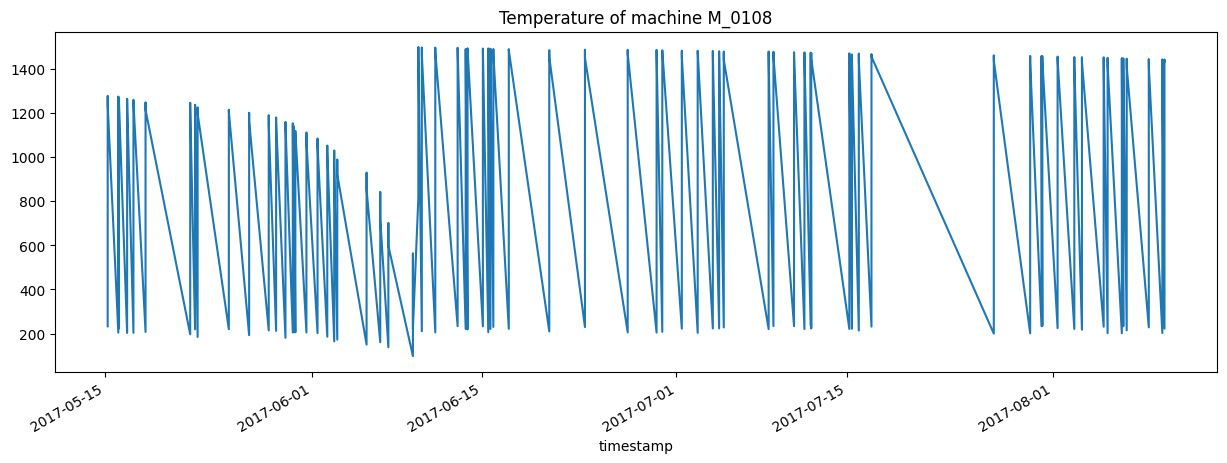

In [124]:
from matplotlib import pyplot as plt
m108['pressure'].plot( figsize=(15, 5), title='Temperature of machine M_0108')
plt.show()

NameError: name 'plt' is not defined

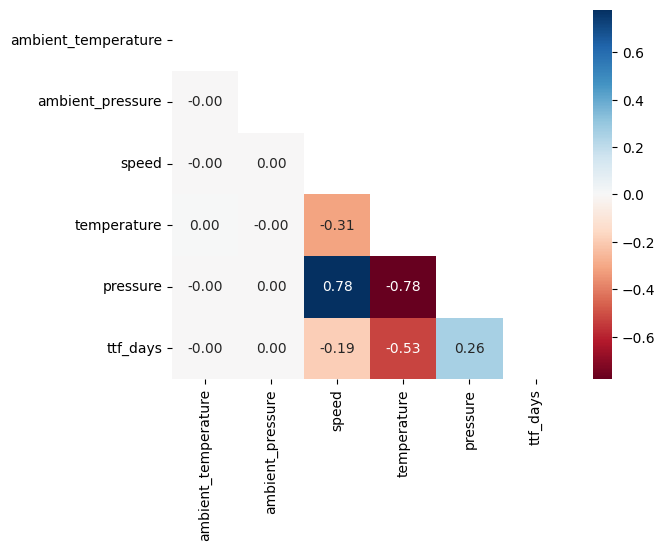

In [9]:
import seaborn as sns
import numpy as np

corr_df = ext_tel_df[(ext_tel_df['speed_desired'] > 0) & (ext_tel_df['ttf_days'] >= 0)][['ambient_temperature', 'ambient_pressure', 'speed', 'temperature', 'pressure', 'ttf_days']]
corr = corr_df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, fmt='.2f')
plt.rcParams['figure.figsize'] = (10, 10)

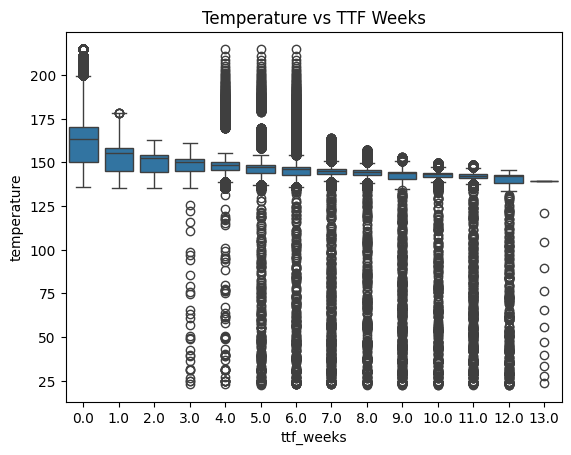

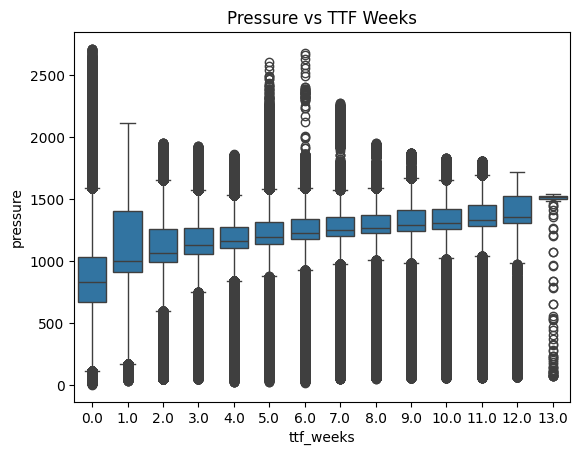

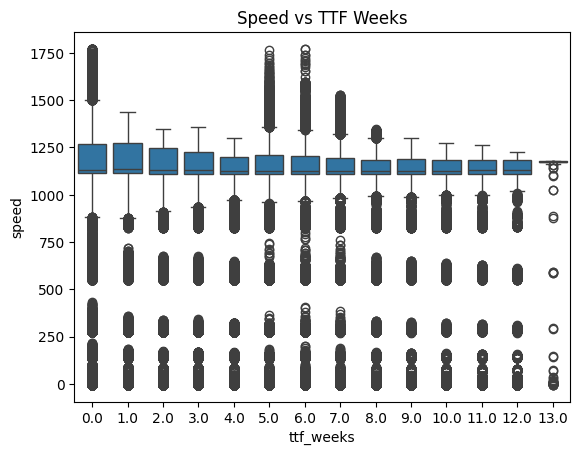

In [11]:
ext_tel_df
import matplotlib.pyplot as plt

# make a new column ttf_weeks based on ttf_days
fe_df = ext_tel_df.copy()
fe_df['ttf_weeks'] = fe_df['ttf_days'] // 7

fe_df = fe_df.reset_index()
sns.boxplot(data=fe_df, x='ttf_weeks', y='temperature')
plt.title('Temperature vs TTF Weeks')
plt.show()

# make a boxplot of ttf_weeks vs pressure
sns.boxplot(data=fe_df, x='ttf_weeks', y='pressure')
plt.title('Pressure vs TTF Weeks')
plt.show()

# make a boxplot of ttf_weeks vs speed
sns.boxplot(data=fe_df, x='ttf_weeks', y='speed')
plt.title('Speed vs TTF Weeks')
plt.show()

In [21]:
fe_df[ (fe_df['ttf_days'] < 16)]

,timestamp,speed_desired,ambient_temperature,ambient_pressure,speed,temperature,pressure,machineID,failure_time,ttf_days,failure_soon,ttf_weeks
1457780,2017-05-25 04:26:00,1000,20.05,101.05,590.13,151.30,220.28,M_0108,2017-06-09 07:51:13,15.0,0,2.0
1457781,2017-05-25 04:26:01,1000,20.03,101.02,889.39,151.33,458.63,M_0108,2017-06-09 07:51:13,15.0,0,2.0
1457782,2017-05-25 04:26:02,1000,19.98,100.99,1039.08,151.26,732.60,M_0108,2017-06-09 07:51:13,15.0,0,2.0
1457783,2017-05-25 04:26:03,1000,20.09,101.03,1118.20,151.15,888.20,M_0108,2017-06-09 07:51:13,15.0,0,2.0
1457784,2017-05-25 04:26:04,1000,20.06,100.96,1154.18,151.18,1041.07,M_0108,2017-06-09 07:51:13,15.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12490153,2017-08-14 15:27:34,1000,20.08,101.09,1706.35,149.57,2084.47,M_0380,2017-08-14 15:27:39,0.0,1,0.0
12490154,2017-08-14 15:27:35,1000,19.92,101.02,1711.69,149.47,2090.92,M_0380,2017-08-14 15:27:39,0.0,1,0.0
12490155,2017-08-14 15:27:36,1000,19.99,101.08,1720.60,149.59,2098.11,M_0380,2017-08-14 15:27:39,0.0,1,0.0
12490156,2017-08-14 15:27:37,1000,20.07,100.94,1741.91,149.48,2144.91,M_0380,2017-08-14 15:27:39,0.0,1,0.0


In [145]:
# split the data into train and test where train is 90% of the data and test is 10%
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(fe_df, test_size=0.1, random_state=42)

X_train = train_df[['ambient_temperature', 'ambient_pressure', 'speed', 'temperature', 'pressure']]
Y_train = train_df['failure_soon']
Y_ttf_train = train_df['ttf_days']
# replace all nan with -1
Y_ttf_train = Y_ttf_train.fillna(-1)

X_test = test_df[['ambient_temperature', 'ambient_pressure', 'speed', 'temperature', 'pressure']]
Y_test = test_df['failure_soon']
Y_ttf_test = test_df['ttf_days']
# replace all nan with -1
Y_ttf_test = Y_ttf_test.fillna(-1)

print('Train Size:', X_train.shape)
print('Test Size:', X_test.shape)

train_positive = Y_train.sum()
train_negative = Y_train.shape[0] - train_positive
print(f'Train Total: {X_train.shape[0]}, Train Positive: {train_positive}, Ratio: {train_positive / X_train.shape[0]}')
print(f'Scale Positive Weight Ration:', (train_negative / train_positive))
print(f'Test Total: {X_test.shape[0]}, Test Positive: {Y_test.sum()}, Ratio: {Y_test.sum() / X_test.shape[0]}')

Train Size: (11279676, 5)
Test Size: (1253298, 5)
Train Total: 11279676, Train Positive: 269679, Ratio: 0.023908399496581283
Scale Positive Weight Ration: 40.82630460658783
Test Total: 1253298, Test Positive: 29902, Ratio: 0.023858651334319532


In [138]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

best_lgbm = {
    'colsample_bytree': 0.2716140673543791,
    'learning_rate': 0.03318188911924709,
    'max_depth': 8.0,
    'min_child_samples': 38.0,
    'n_estimators': 320.0,
    'num_leaves': 85.0,
    'reg_alpha': 0.2758911770404832,
    'reg_lambda': 0.5282289333716691,
    'subsample': 0.7207598937645425
}
best_lgbm['max_depth'] = int(best_lgbm['max_depth'])
best_lgbm['num_leaves'] = int(best_lgbm['num_leaves'])
best_lgbm['n_estimators'] = int(best_lgbm['n_estimators'])
best_lgbm['min_child_samples'] = int(best_lgbm['min_child_samples'])
best_lgbm['scale_pos_weight '] = 50

model_lgbm = lgb.LGBMClassifier(**best_lgbm)
model_lgbm.fit(X_train, Y_train)
y_pred = model_lgbm.predict(X_test)
y_pred_proba = model_lgbm.predict_proba(X_test)[:,1]
auc = roc_auc_score(Y_test, y_pred_proba)
print(f'AUC: {auc}')

[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Info] Number of positive: 269679, number of negative: 11009997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 11279676, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023908 -> initscore=-3.709327
[LightGBM] [Info] Start training from score -3.709327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [136]:
from sklearn.metrics import confusion_matrix


def evaluate_model(model, X_test, Y_test, name: str):
    print(f'{"Model Evaluation":-^50}')
    print(f'Model: {name}')
    print('N: ', X_test.shape[0])
    print('Positive: ', Y_test.sum())
    # 1. Get Confusion Matrix
    predictions = model.predict(X_test)
    confusion = confusion_matrix(Y_test, predictions)
    print(f'Confusion Matrix:\n{confusion}')

    # print seaborn heatmap of the confusion matrix
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 2. Get simple scores: Precision, Accuracy, Recall, F1
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    precision = precision_score(Y_test, predictions)
    recall = recall_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions)
    accuracy = accuracy_score(Y_test, predictions)
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1: {f1:.2f}')

    # 3. Evaluate Precision-Recall Curve for different probability thresholds
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(Y_test, model.predict_proba(X_test)[:, 1])
    # plot on Y precision, on X recall as thresholds change
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # 4. Evaluate ROC AUC Curve
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, marker='.')
    plt.title('ROC AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    # 5. Evaluate ROC AUC Score
    auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
    print(f'ROC AUC: {auc:.2f}')
    

-----------------Model Evaluation-----------------
Model: LGBM
N:  1253298
Positive:  29902
[LightGBM] [Warning] Unknown parameter: 50
Confusion Matrix:
[[1218877    4519]
 [   8267   21635]]


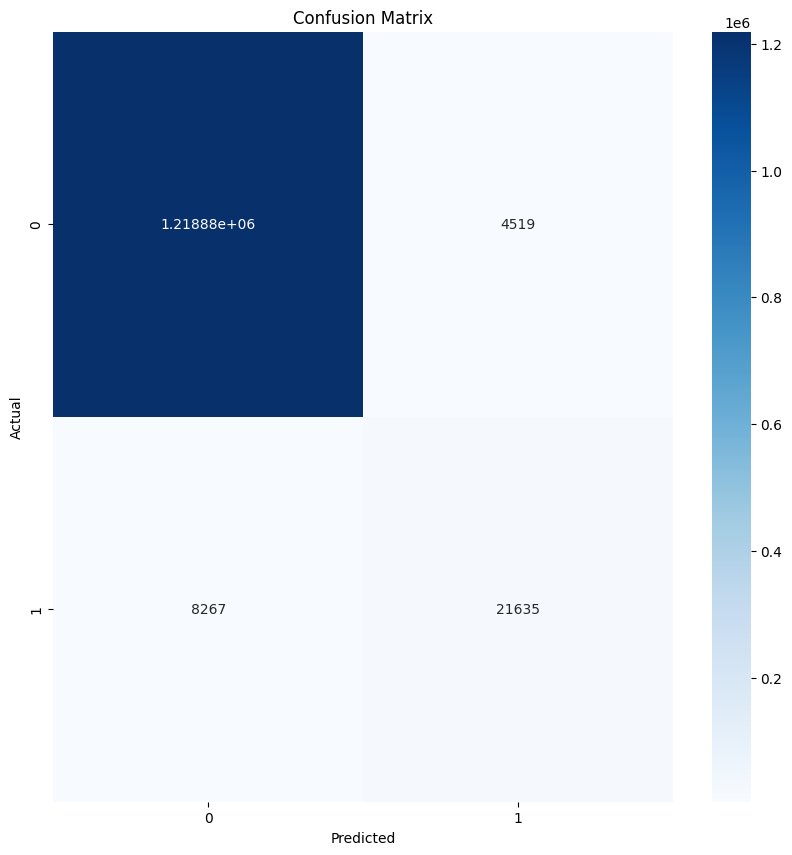

Precision: 0.83
Recall: 0.72
Accuracy: 0.99
F1: 0.77
[LightGBM] [Warning] Unknown parameter: 50


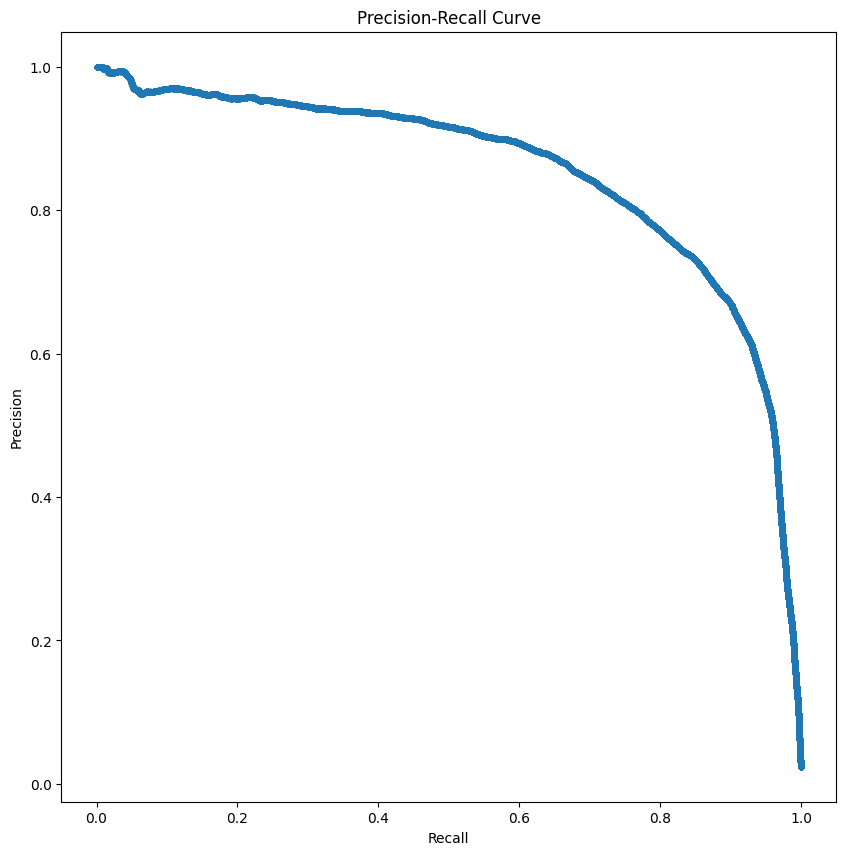

[LightGBM] [Warning] Unknown parameter: 50


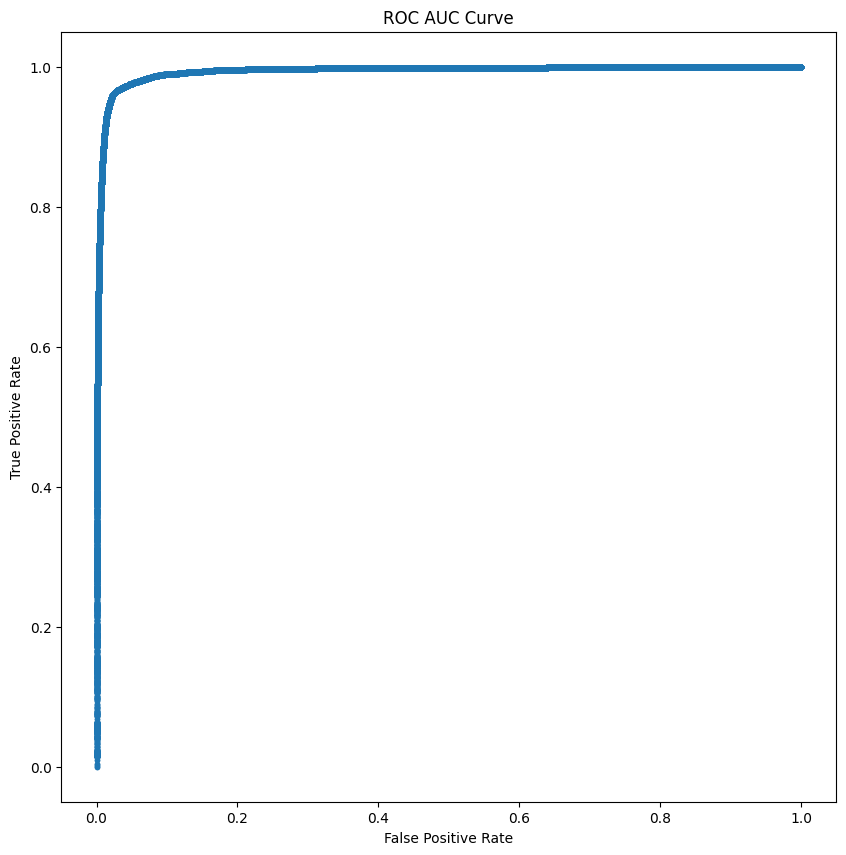

[LightGBM] [Warning] Unknown parameter: 50
ROC AUC: 0.99


In [139]:
evaluate_model(model_lgbm, X_test, Y_test, 'LGBM')


In [ ]:
from sklearn.metrics import confusion_matrix


def evaluate_model(model, X_test, Y_test, name: str):
    print(f'{"Model Evaluation":-^50}')
    print(f'Model: {name}')
    print('N: ', X_test.shape[0])
    print('Positive: ', Y_test.sum())
    # 1. Get Confusion Matrix
    predictions = model.predict(X_test)
    confusion = confusion_matrix(Y_test, predictions)
    print(f'Confusion Matrix:\n{confusion}')

    # print seaborn heatmap of the confusion matrix
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 2. Get simple scores: Precision, Accuracy, Recall, F1
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    precision = precision_score(Y_test, predictions)
    recall = recall_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions)
    accuracy = accuracy_score(Y_test, predictions)
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1: {f1:.2f}')

    # 3. Evaluate Precision-Recall Curve for different probability thresholds
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(Y_test, model.predict_proba(X_test)[:, 1])
    # plot on Y precision, on X recall as thresholds change
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # 4. Evaluate ROC AUC Curve
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, marker='.')
    plt.title('ROC AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    # 5. Evaluate ROC AUC Score
    auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
    print(f'ROC AUC: {auc:.2f}')
    

In [157]:
# remove best_lgbm['scale_pos_weight '] = 50
if 'scale_pos_weight ' in best_lgbm:
    del best_lgbm['scale_pos_weight ']

if 'reg_alpha' in best_lgbm:
    del best_lgbm['reg_alpha']

if 'reg_lambda' in best_lgbm:
    del best_lgbm['reg_lambda']

best_lgbm['verbose'] = 5000
best_lgbm
best_lgbm['boosting_type'] = 'gbdt'

lgbm_regressor = lgb.LGBMRegressor()
lgbm_regressor.fit(X_train, Y_ttf_train,
                   eval_set=[(X_train, Y_ttf_train), (X_test, Y_ttf_test)])




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 11279676, number of used features: 5
[LightGBM] [Info] Start training from score 5.861100


LGBMRegressor()

In [172]:
# evaluate lgbm regressor with mean squared error
from sklearn.metrics import mean_squared_error
y_pred = lgbm_regressor.predict(X_test)
mse = mean_squared_error(Y_ttf_test, y_pred)
print(f'Mean Squared Error Test: {mse:.2f}')

# grab some samples from the test set and compare the predicted ttf_days with the actual ttf_days
samples = X_test.sample(10)
output = samples.copy()
output['ttf_days'] = Y_ttf_test.loc[samples.index]
output['ttf_days_pred'] = lgbm_regressor.predict(samples)
output


Mean Squared Error Test: 191.81


,ambient_temperature,ambient_pressure,speed,temperature,pressure,ttf_days,ttf_days_pred
2702651,19.97,100.94,-1.51,135.15,323.94,-1.0,1.150346
1722802,19.99,100.92,140.42,136.82,839.17,-1.0,0.836699
6128296,20.00,101.03,1146.13,140.12,1423.51,-1.0,-0.940315
8489829,20.09,100.95,1137.41,135.87,1550.37,-1.0,-0.967423
9738523,19.91,100.91,1487.32,145.94,1832.77,0.0,1.421424
9134239,19.94,101.02,1184.22,148.91,1261.55,-1.0,16.936741
9017065,20.03,101.06,1144.53,136.79,1560.40,-1.0,-0.990574
3424346,19.99,100.97,1136.76,154.22,1050.02,18.0,13.694978
4051500,19.99,101.03,1104.61,149.08,1126.78,34.0,24.411857
6474014,20.09,101.09,1126.18,135.65,1574.78,-1.0,-0.985444
